GPU is available and being used for training.
Found 4000 images belonging to 10 classes.
Found 1000 files belonging to 10 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/125 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.1562 - loss: 2.7536  

I0000 00:00:1713339197.191555      98 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713339197.245894      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.3114 - loss: 2.0046

W0000 00:00:1713339248.061077      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 449ms/step - accuracy: 0.3125 - loss: 2.0011 - val_accuracy: 0.7450 - val_loss: 0.8536
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 323ms/step - accuracy: 0.6414 - loss: 0.9827 - val_accuracy: 0.8110 - val_loss: 0.6081
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 329ms/step - accuracy: 0.7389 - loss: 0.7350 - val_accuracy: 0.8470 - val_loss: 0.5036
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 326ms/step - accuracy: 0.7760 - loss: 0.6276 - val_accuracy: 0.8580 - val_loss: 0.4441
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 327ms/step - accuracy: 0.7952 - loss: 0.5546 - val_accuracy: 0.8560 - val_loss: 0.4068
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 330ms/step - accuracy: 0.8315 - loss: 0.4923 - val_accuracy: 0.8730 - val_loss: 0.3752
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 325ms/step - accuracy: 0.8280 - loss: 0.4797 - val_accuracy: 0.8950 - val_loss: 0.3260
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 327ms/step - accuracy: 0.8450 - loss: 0.4419 - val

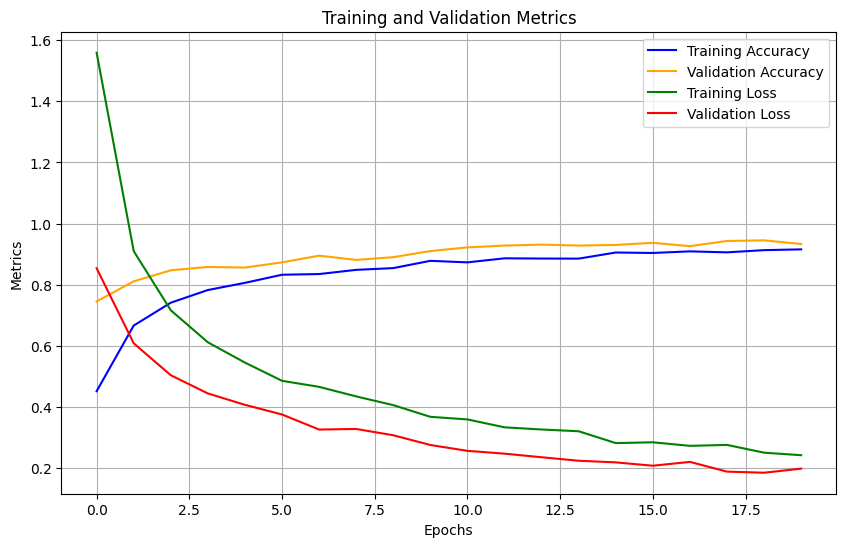

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Define your dataset directories
train_data_dir = '/kaggle/input/datasetmosquito/dataset/dataset/trainset'
val_data_dir = '/kaggle/input/datasetmosquito/dataset/dataset/testset'

# Image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Check if GPU is available and being used
if tf.config.list_physical_devices('GPU'):
    print("GPU is available and being used for training.")
else:
    print("GPU is not available. Training on CPU.")

# Load the dataset with data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_ds = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

num_classes = len(train_ds.class_indices)

# Define the model
pretrained_model = ResNet50(
    include_top=False,
    input_shape=(img_height, img_width, 3),
    pooling='avg',
    weights='imagenet'
)

model = Sequential([
    pretrained_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout regularization
    layers.Dense(num_classes, activation='softmax')  # Output layer with 'num_classes' units
])

# Freeze the pretrained layers
for layer in pretrained_model.layers:
    layer.trainable = False

# Compile the model with a different learning rate
optimizer = Adam(learning_rate=0.0001)  # Changed learning rate
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

# Plotting accuracy and loss in a single plot
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss', color='green')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')

plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.show()


In [4]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Load the validation dataset with class labels
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

# Assuming y_true and y_pred are the true labels and predicted labels respectively
y_true = []
y_pred = []

for images, labels in val_ds:
    # Predict the labels for the batch of images
    batch_pred = model.predict(images)
    # Convert the predicted probabilities to class labels by selecting the class with the highest probability
    batch_pred_labels = np.argmax(batch_pred, axis=-1)
    # Append true labels and predicted labels for the batch
    y_true.extend(labels.numpy())
    y_pred.extend(batch_pred_labels)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Found 1000 files belonging to 10 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

W0000 00:00:1713340316.355008      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

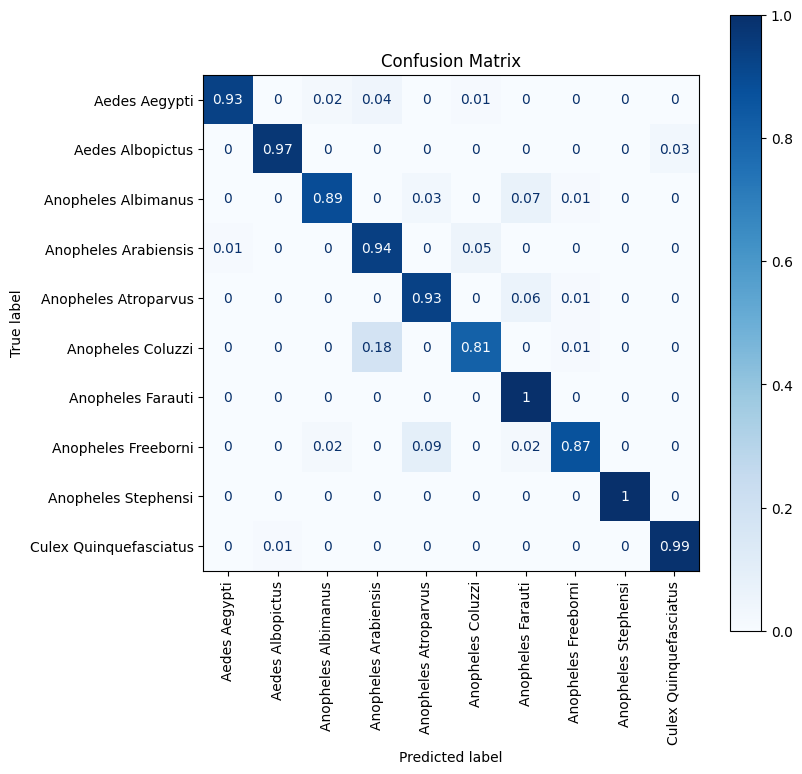

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define class names manually
class_names = ['Aedes Aegypti', 'Aedes Albopictus','Anopheles Albimanus','Anopheles Arabiensis','Anopheles Atroparvus','Anopheles Coluzzi','Anopheles Farauti','Anopheles Freeborni','Anopheles Stephensi', 'Culex Quinquefasciatus']

# Get the true labels and predictions for the validation set
val_true_labels = []
val_predictions = []

for images, labels in val_ds:
    val_true_labels.extend(labels.numpy())
    predictions = model.predict(images)
    val_predictions.extend(np.argmax(predictions, axis=1))

# Create the confusion matrix
cm = confusion_matrix(val_true_labels, val_predictions, normalize='true')

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()
